In [20]:
import numpy as np
import pandas as pd
import glob as glob
import matplotlib.pyplot as plt
import datetime
%matplotlib inline
plt.style.use('fivethirtyeight')

from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<a href="javascript:code_toggle()">Show/Hide Code</a>.''')

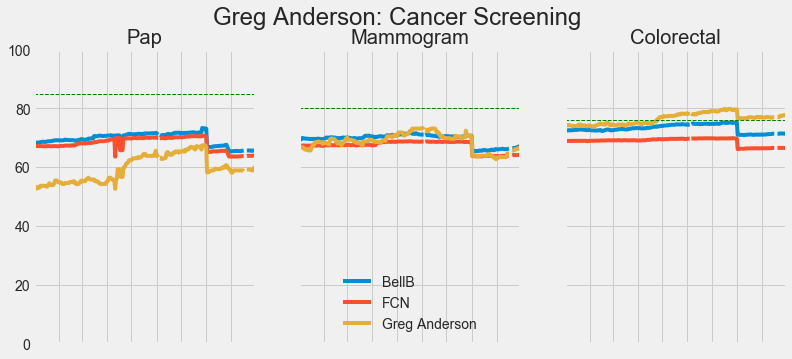

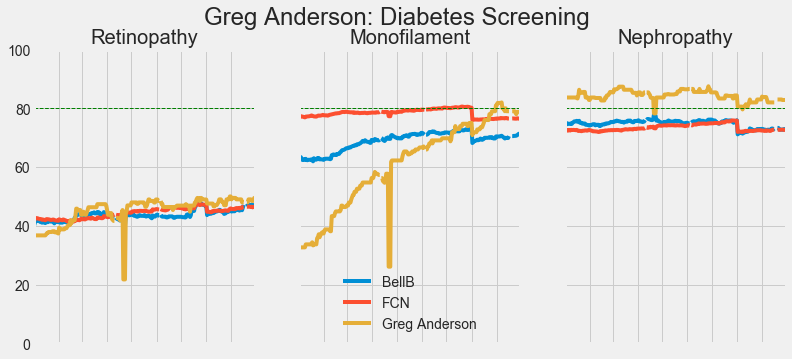

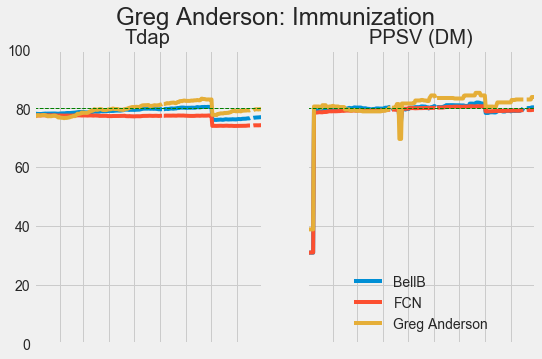

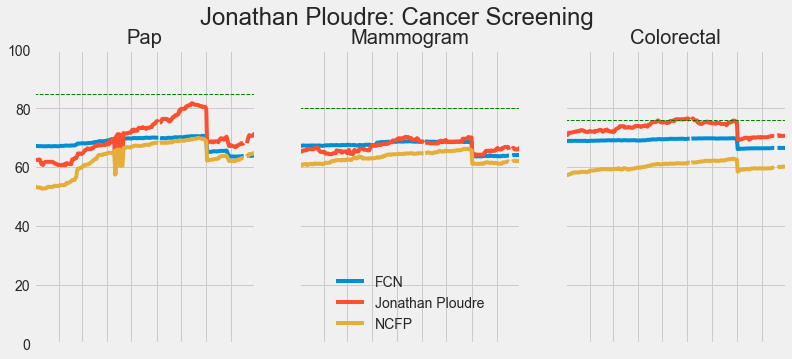

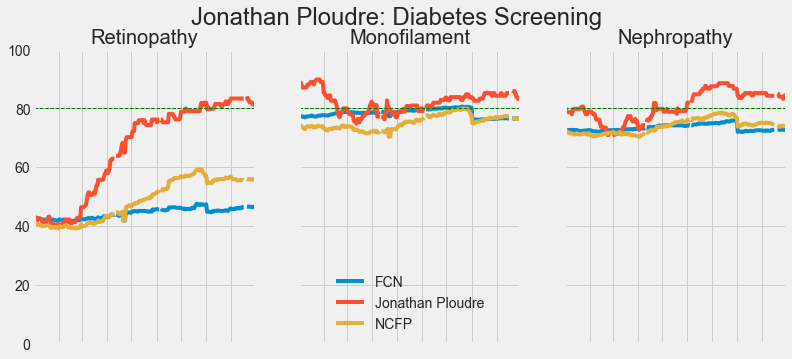

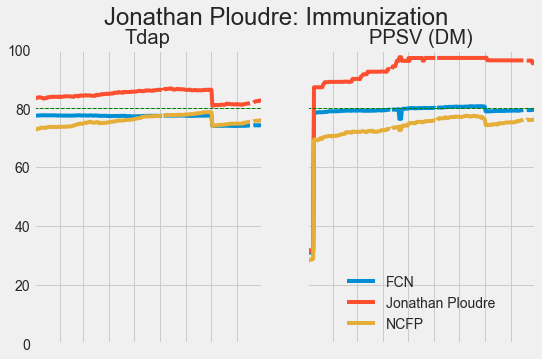

In [26]:
def create_individual_graphs(individual, clinic):
    dfs = []
    df = pd.read_csv('FCN.csv', 
                     usecols=["lastupdate", "metricname", "ptsseen_avg"],
                    parse_dates=["lastupdate"])
    df['Provider'] = "FCN"
    # Normalize Dates
    df['lastupdate'] = df['lastupdate'].apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day))
    dfs.append(df)

    clinic_csv = './clinic/' + clinic + '.csv'
    df = pd.read_csv(clinic_csv, 
                     usecols=["lastupdate", "metricname", "ptsseen_avg"],
                    parse_dates=["lastupdate"])
    df['Provider'] = str(clinic)
    df['lastupdate'] = df['lastupdate'].apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day))
    dfs.append(df)
    
    individual_csv = './provider/' + individual + '.csv'
    df = pd.read_csv(individual_csv, 
                     usecols=["lastupdate", "metricname", "ptsseen_avg"],
                    parse_dates=["lastupdate"])
    df['Provider'] = individual.replace('_'," ")
    df['lastupdate'] = df['lastupdate'].apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day))
    dfs.append(df)

    big_frame = pd.concat(dfs, ignore_index=True)
    big_frame = big_frame.pivot_table(index='lastupdate', 
                    columns=['metricname','Provider'], 
                    values="ptsseen_avg")
    
    # First Figure: Cancer Screening
    fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12,6))
    fig.suptitle(individual.replace('_'," ") + ": Cancer Screening", fontsize=24, )
    
    big_frame['PAP'].plot(ax=ax[0], legend=False)
    ax[0].set(title='Pap', ylim=(0,100), xlabel="")
    ax[0].axhline(y=85, color='g', label='Target', linestyle='--', linewidth=1)
    ax[0].xaxis.set_major_formatter(plt.NullFormatter())

    big_frame['MAMMO'].plot(ax=ax[1])
    ax[1].set(title='Mammogram', ylim=(0,100), xlabel="")
    ax[1].legend(loc="lower center", ncol=1)
    ax[1].axhline(y=80, color='g', label='Target', linestyle='--', linewidth=1)
    ax[1].xaxis.set_major_formatter(plt.NullFormatter())

    big_frame['COLORECTAL'].plot(ax=ax[2], legend=False)
    ax[2].set(title='Colorectal', ylim=(0,100), xlabel="")
    ax[2].axhline(y=76, color='g', label='Target', linestyle='--', linewidth=1)
    ax[2].xaxis.set_major_formatter(plt.NullFormatter())

    # Second Figure: Diabetes Screening
    fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12,6))
    fig.suptitle(individual.replace('_'," ") + ": Diabetes Screening", fontsize=24)

    big_frame['DM-EYE'].plot(ax=ax[0], legend=False)
    ax[0].set(title='Retinopathy', ylim=(0,100), xlabel="")
    ax[0].axhline(y=80, color='g', label='Target', linestyle='--', linewidth=1)
    ax[0].xaxis.set_major_formatter(plt.NullFormatter())

    big_frame['DM-FOOT'].plot(ax=ax[1])
    ax[1].set(title='Monofilament', ylim=(0,100), xlabel="")
    ax[1].legend(loc="lower center", ncol=1)
    ax[1].axhline(y=80, color='g', label='Target', linestyle='--', linewidth=1)
    ax[1].xaxis.set_major_formatter(plt.NullFormatter())

    big_frame['DM-KIDNEY'].plot(ax=ax[2], legend=False)
    ax[2].set(title='Nephropathy', ylim=(0,100), xlabel="")
    ax[2].axhline(y=80, color='g', label='Target', linestyle='--', linewidth=1)
    ax[2].xaxis.set_major_formatter(plt.NullFormatter())
    
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(8,6))
    fig.suptitle(individual.replace('_'," ") + ": Immunization", fontsize=24)

    big_frame['TDAP'].plot(ax=ax[0], legend=False)
    ax[0].set(title='Tdap', ylim=(0,100), xlabel="")
    ax[0].axhline(y=80, color='g', label='Target', linestyle='--', linewidth=1)
    ax[0].xaxis.set_major_formatter(plt.NullFormatter())

    big_frame['DM-PPSV'].plot(ax=ax[1])
    ax[1].set(title='PPSV (DM)', ylim=(0,100), xlabel="")
    ax[1].legend(loc="lower center", ncol=1)
    ax[1].axhline(y=80, color='g', label='Target', linestyle='--', linewidth=1)
    ax[1].xaxis.set_major_formatter(plt.NullFormatter())

big_frame = create_individual_graphs("Greg_Anderson", "BellB")
big_frame = create_individual_graphs("Jonathan_Ploudre", "NCFP")